Modelo LSTM para prever o parâmetro DBO 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import math
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize']= 18
plt.rcParams['ytick.labelsize']= 18
plt.rcParams.update({'font.size':18})

In [15]:
str_files = ''

#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'dbo.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

In [16]:
#df.head()

In [17]:
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']
#z.info()

In [18]:
z = z.dropna(axis=1,how='any')
#for field in z.columns:
    #print(field,'NaN',z[field].isnull().sum())
#print(len(z))

In [19]:
trainingd = z.resample('3M').mean()
trainingd
data = trainingd.iloc[:,1:2].values

train = trainingd.iloc[0:133,1:2].values  
test = trainingd.iloc[133:,1:2].values   
print('treino:',len(train))
print('teste:',len(test))
len(test)

treino: 133
teste: 33


33

In [20]:
sc = MinMaxScaler()
train_normalizado = sc.fit_transform(train)

In [21]:
timestamp = 8
previsores = []
dbo_real    = []
for i in range(timestamp, len(train)):
    previsores.append(train_normalizado[i-timestamp:i, 0])
    dbo_real.append(train_normalizado[i, 0])
previsores, dbo_real = np.array(previsores), np.array(dbo_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(125, 8, 1)

In [22]:
print("Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 10, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 10, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, dbo_real, epochs = 100, batch_size = 32)


Rede Neural LSTM com 10 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 114ms/sample - loss: 0.2128
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1789
Epoch 3/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.1486
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1177
Epoch 5/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0878
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0680
Epoch 7/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0548
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0412
Epoch 9/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0413
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0419
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 2ms/sample - loss: 0.0276
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0298
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0299
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0283
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0308


In [24]:
dbo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

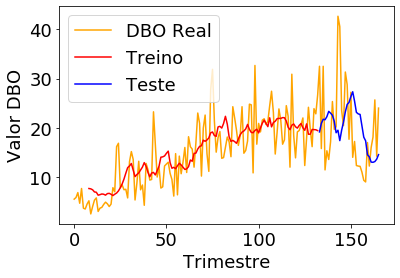

In [25]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='DBO Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor DBO')
plt.legend(loc='best')
plt.show()

In [26]:
print('Previsão (média):',round(previsoes.mean(),2))
print('DBO Real (média):', round(dbo_real_teste.mean(),2))
print('Diferença (média):', round(dbo_real_teste.mean() - previsoes.mean(),2))

Previsão (média): 20.16
DBO Real (média): 20.01
Diferença (média): -0.15


In [27]:
train_score10 = model.evaluate(previsores, dbo_real, verbose=0)
ph10_mse  = train_score10
ph10_rmse = math.sqrt(train_score10)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score10, math.sqrt(train_score10)))
#test_score10 = mdl.evaluate(X_test, y_test, verbose=0)
#print('Pontuação de teste: {:.2f} MSE ({:.2f} RMSE)'.format(test_score10, math.sqrt(test_score10)))

Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [28]:
print("Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 25, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, dbo_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 25 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 110ms/sample - loss: 0.1983
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1476
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0929
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0474
Epoch 5/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0430
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0498
Epoch 7/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0377
Epoch 8/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0307
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0341
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0406
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0272
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0271
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0274
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0300
Epoch 100/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0263


In [29]:
dbo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

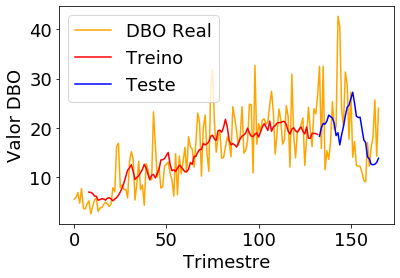

Previsão (média): 19.53
DBO Real (média): 20.01
Diferença (média): 0.48
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [30]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='DBO Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor DBO')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('DBO Real (média):', round(dbo_real_teste.mean(),2))
print('Diferença (média):', round(dbo_real_teste.mean() - previsoes.mean(),2))

train_score25 = model.evaluate(previsores, dbo_real, verbose=0)
ph25_mse  = train_score25
ph25_rmse = math.sqrt(train_score25)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score25, math.sqrt(train_score25)))


In [31]:
print("Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100")
model = Sequential() 

model.add(LSTM(units = 50, return_sequences = True, input_shape = (previsores.shape[1], 1))) 
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False)) 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

#es = EarlyStopping(monitor='val_loss',mode='auto',verbose = 1,patience=5)

model.fit(previsores, dbo_real, epochs = 100, batch_size = 32)

Rede Neural LSTM com 50 neuronios nas camadas de entrada e oculta - epocas:100
Train on 125 samples
Epoch 1/100
125/125 [==============================] - 14s 116ms/sample - loss: 0.1883
Epoch 2/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.1003
Epoch 3/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0392
Epoch 4/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0517
Epoch 5/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0352
Epoch 6/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0366
Epoch 7/100
125/125 [==============================] - 0s 4ms/sample - loss: 0.0345
Epoch 8/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0336
Epoch 9/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0298
Epoch 10/100
125/125 [==============================] - 0s 3ms/sample - loss: 0.0278
Epoch 11/100
125/125 [==============================] - 

125/125 [==============================] - 0s 3ms/sample - loss: 0.0235
Epoch 97/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0249
Epoch 98/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0265
Epoch 99/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0255
Epoch 100/100
125/125 [==============================] - 0s 2ms/sample - loss: 0.0257


In [32]:
dbo_real_teste = test
entradas = data[len(data) - len(test) - timestamp:]
entradas = entradas.reshape(-1, 1)
entradas = sc.transform(entradas)

X_teste = []
for i in range(timestamp, timestamp + len(test)):
    X_teste.append(entradas[i-timestamp:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
previsoes = model.predict(X_teste)
previsoes = sc.inverse_transform(previsoes)

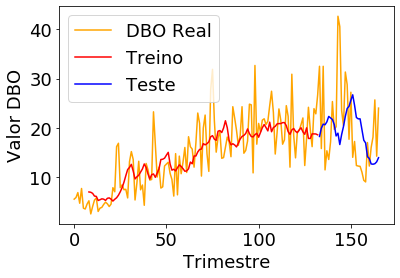

Previsão (média): 19.4
DBO Real (média): 20.01
Diferença (média): 0.6
Pontuação de Treino: 0.02 MSE (0.15 RMSE)


In [33]:
previsoes_treino = model.predict(previsores)
previsoes_treino = sc.inverse_transform(previsoes_treino)

train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[timestamp: len(previsoes_treino) + timestamp, :] = previsoes_treino

test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+(timestamp):len(data), :] = previsoes

plt.plot(data, label='DBO Real', color='orange')
plt.plot(train_predict_plot, color = 'red', label = 'Treino')
plt.plot(test_predict_plot, color = 'blue', label = 'Teste')
plt.title('')
plt.xlabel('Trimestre')
plt.ylabel('Valor DBO')
plt.legend(loc='best')
plt.show()

print('Previsão (média):',round(previsoes.mean(),2))
print('DBO Real (média):', round(dbo_real_teste.mean(),2))
print('Diferença (média):', round(dbo_real_teste.mean() - previsoes.mean(),2))

train_score50 = model.evaluate(previsores, dbo_real, verbose=0)
ph50_mse  = train_score50
ph50_rmse = math.sqrt(train_score50)

print('Pontuação de Treino: {:.2f} MSE ({:.2f} RMSE)'.format(train_score50, math.sqrt(train_score50)))
    


In [34]:
ph_media_mse = (ph10_mse+ph25_mse+ph50_mse)/3
ph_media_rmse = (ph10_rmse+ph25_rmse+ph50_rmse)/3

print('dbo_media_mse:', round(ph_media_mse,3))
print('dbo_media_rmse:', round(ph_media_rmse,3))

dbo_media_mse: 0.023
dbo_media_rmse: 0.152
